# 2023 Spring Event 분석

모든 통계는 이벤트 기간 2023/05/03(수) ~ 2023/05/15(월) 동안의 지표입니다.

In [1]:
# import
from pymongo import MongoClient
from bson.objectid import ObjectId
from datetime import datetime, timezone, timedelta
import re
import pandas as pd
import matplotlib.pyplot as plt

# timezone = KST
KST = timezone(timedelta(hours=9))

# event time
eventStart = datetime(2023, 5, 3, 0, 0, 0, tzinfo=KST)
eventEnd = datetime(2023, 5, 15, 23, 59, 59, tzinfo=KST)
eventQuery = {"$gte": eventStart, "$lte": eventEnd}

In [2]:
# connect with mongo
client = MongoClient("mongodb://localhost:27017/")
db = client["taxi"]
logs = client["logs"]

## 만들어진 방

In [3]:
totRooms = list(db.rooms.find())
eventRooms = list(db.rooms.find({"madeat": eventQuery}))
eventNonZeroRooms = list(filter(lambda x: len(x["part"]) != 0, eventRooms))
eventMatchedRooms = list(filter(lambda x: len(x["part"]) > 1, eventRooms))

print("전체 방의 개수 = {}".format(len(totRooms)))
print("이벤트 기간 동안 생성된 전체 방 개수 = {}".format(len(eventRooms)))
print("이벤트 기간 동안 생성되었고 참여 인원이 0명이 아닌 전체 방 개수 = {}".format(len(eventNonZeroRooms)))
print("이벤트 기간 동안 생성되었고 매칭된 전체 방 개수 = {}".format(len(eventMatchedRooms)))

전체 방의 개수 = 528
이벤트 기간 동안 생성된 전체 방 개수 = 319
이벤트 기간 동안 생성되었고 참여 인원이 0명이 아닌 전체 방 개수 = 229
이벤트 기간 동안 생성되었고 매칭된 전체 방 개수 = 113


## 출발지/도착지 경로

In [4]:
locations = list(db.locations.find())
originDest = []
for origin in locations:
    for dest in locations:
        if origin['_id'] != dest['_id']:
            rooms = list(db.rooms.find({"from": origin['_id'], "to": dest['_id'], "madeat": eventQuery}))
            count = [len(list(filter(lambda x: len(x["part"]) == i, rooms))) for i in range(5)]
            if sum(count) == 0: break
            originDest.append({
                "path": "{} -> {}".format(origin["koName"], dest["koName"]),
                "count": count,
            })
            
originDest.sort(key=lambda x: sum(x["count"]), reverse=True)
divide = lambda x, y: x / y if y != 0 else 0
totCountRoom = sum([sum(x['count']) for x in originDest])

print("전체 방 개수 = {}".format(totCountRoom))
pd.DataFrame(data={
    "경로": [x['path'] for x in originDest],
    "방개수": [sum(x['count']) for x in originDest],
    "방개수 / 전체": [sum(x['count']) / totCountRoom for x in originDest],
    "참여인원이 4명 / 방개수": [x['count'][4] / sum(x['count']) for x in originDest],
    "참여인원이 3명 / 방개수": [x['count'][3] / sum(x['count']) for x in originDest],
    "참여인원이 2명 / 방개수": [x['count'][2] / sum(x['count']) for x in originDest],
    "참여인원이 1명 / 방개수": [x['count'][1] / sum(x['count']) for x in originDest],
    "참여인원이 0명 / 방개수": [x['count'][0] / sum(x['count']) for x in originDest],
    "매칭 성공 비율": [divide((sum(x['count']) - x['count'][0] - x['count'][1]), (sum(x['count']) - x['count'][0])) for x in originDest],
}).style.hide(axis='index')

전체 방 개수 = 274


경로,방개수,방개수 / 전체,참여인원이 4명 / 방개수,참여인원이 3명 / 방개수,참여인원이 2명 / 방개수,참여인원이 1명 / 방개수,참여인원이 0명 / 방개수,매칭 성공 비율
대전역 -> 카이스트 본원,125,0.456204,0.208000,0.096000,0.112000,0.296000,0.288000,0.584270
카이스트 본원 -> 대전역,109,0.397810,0.110092,0.091743,0.201835,0.330275,0.266055,0.550000
대전복합터미널 -> 카이스트 본원,12,0.043796,0.000000,0.000000,0.250000,0.250000,0.500000,0.500000
서대전역 -> 카이스트 본원,10,0.036496,0.000000,0.000000,0.300000,0.600000,0.100000,0.333333
유성 고속버스터미널 -> 카이스트 본원,8,0.029197,0.000000,0.125000,0.000000,0.625000,0.250000,0.166667
궁동 로데오거리 -> 카이스트 본원,4,0.014599,0.250000,0.250000,0.000000,0.250000,0.250000,0.666667
카이스트 본원 -> 갤러리아 타임월드,2,0.007299,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
대전청사 시외버스터미널 -> 카이스트 본원,2,0.007299,0.000000,0.000000,0.500000,0.500000,0.000000,0.500000
신세계백화점 -> 카이스트 본원,1,0.003650,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
대전청사 시외버스터미널 -> 대전역,1,0.003650,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


## 출발일 별 만들어진 방

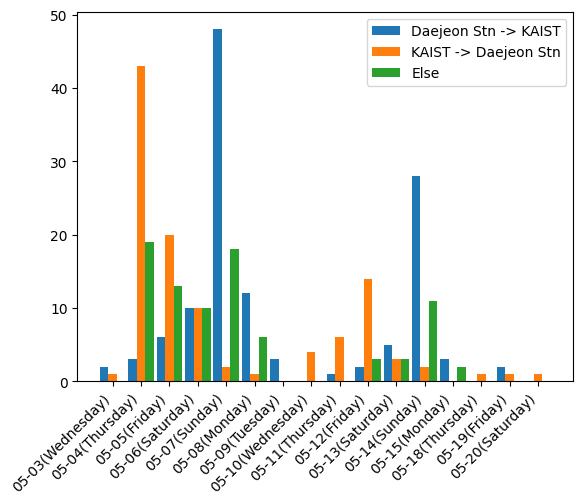

In [5]:
datetime2str = lambda d: d.astimezone(KST).strftime("%m-%d(%A)")

locationDaejeon = db.locations.find_one({"_id": ObjectId("636c70c408eab94199a3cc05")})
locationKaist = db.locations.find_one({"_id": ObjectId("636c70c308eab94199a3cbff")})

createRoomCount = {}
for room in eventRooms:
    datestr = datetime2str(room["time"])
    if datestr not in createRoomCount: createRoomCount[datestr] = [0, 0, 0]
    if room["from"] == locationDaejeon["_id"] and room["to"] == locationKaist["_id"]: createRoomCount[datestr][0] += 1
    elif room["from"] == locationKaist["_id"] and room["to"] == locationDaejeon["_id"]: createRoomCount[datestr][1] += 1
    else: createRoomCount[datestr][2] += 1

createRoomCount = list(createRoomCount.items())
createRoomCount.sort(key=lambda x: x[0])

x = range(len(createRoomCount))
fig, ax = plt.subplots()
plt.bar([i - 0.3 for i in x], [x[1][0] for x in createRoomCount], width=0.3, label="Daejeon Stn -> KAIST")
plt.bar([i for i in x], [x[1][1] for x in createRoomCount], width=0.3, label="KAIST -> Daejeon Stn")
plt.bar([i + 0.3 for i in x], [x[1][2] for x in createRoomCount], width=0.3, label="Else")
plt.xticks(x, [x[0] for x in createRoomCount])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.show()

## 요일 별 만들어진 방

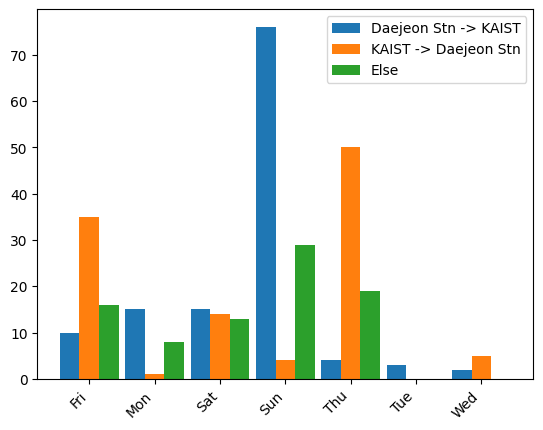

In [6]:
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

createRoomCount = {}
for room in eventRooms:
    weekstr = weekdays[room["time"].weekday()]
    if weekstr not in createRoomCount: createRoomCount[weekstr] = [0, 0, 0]
    if room["from"] == locationDaejeon["_id"] and room["to"] == locationKaist["_id"]: createRoomCount[weekstr][0] += 1
    elif room["from"] == locationKaist["_id"] and room["to"] == locationDaejeon["_id"]: createRoomCount[weekstr][1] += 1
    else: createRoomCount[weekstr][2] += 1

createRoomCount = list(createRoomCount.items())
createRoomCount.sort(key=lambda x: x[0])

x = range(len(createRoomCount))
fig, ax = plt.subplots()
plt.bar([i - 0.3 for i in x], [x[1][0] for x in createRoomCount], width=0.3, label="Daejeon Stn -> KAIST")
plt.bar([i for i in x], [x[1][1] for x in createRoomCount], width=0.3, label="KAIST -> Daejeon Stn")
plt.bar([i + 0.3 for i in x], [x[1][2] for x in createRoomCount], width=0.3, label="Else")
plt.xticks(x, [x[0] for x in createRoomCount])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.show()

## 호출 API

In [7]:
eventLogs = list(logs.logs.find({"timestamp": eventQuery}))

apiCount = {}
print("전체 API 호출 log 개수 : {}".format(len(eventLogs)))
for log in eventLogs:
    apiName = log["request"]
    apiName = re.sub(r'(?<=\=)[^&]*', '', apiName) # 매개변수 제거
    if apiName.startswith("GET /admin"): apiName = "SET /admin"
    if apiName.startswith("POST /admin"): apiName = "SET /admin"
    if apiName.startswith("GET /docs"): apiName = "SET /docs"
    if not apiName.startswith("GET /rooms/search?isHome=") and apiName.startswith("GET /rooms/search"): apiName = "SET /rooms/search"
    if apiName not in apiCount: apiCount[apiName] = 0
    apiCount[apiName] += 1

apiCount = list(apiCount.items())
apiCount.sort(key=lambda x: x[1], reverse=True)

pd.DataFrame(data={
    "API": [x[0] for x in apiCount],
    "호출 횟수": [x[1] for x in apiCount],
    "호출 횟수 / 전체": [x[1] / len(eventLogs) for x in apiCount],
}).style.hide(axis='index')

전체 API 호출 log 개수 : 74703


API,호출 횟수,호출 횟수 / 전체
GET /rooms/search?isHome=,17735,0.237407
GET /logininfo,9925,0.132859
GET /locations,9289,0.124346
GET /rooms/info?id=,7090,0.094909
SET /rooms/search,6530,0.087413
POST /chats,6254,0.083718
GET /notifications/options,2672,0.035768
POST /chats/load/after,2557,0.034229
GET /auth/app/token/login?accessToken=&deviceToken=,2409,0.032248
POST /chats/send,2237,0.029945


## 일 별 API 호출 횟수

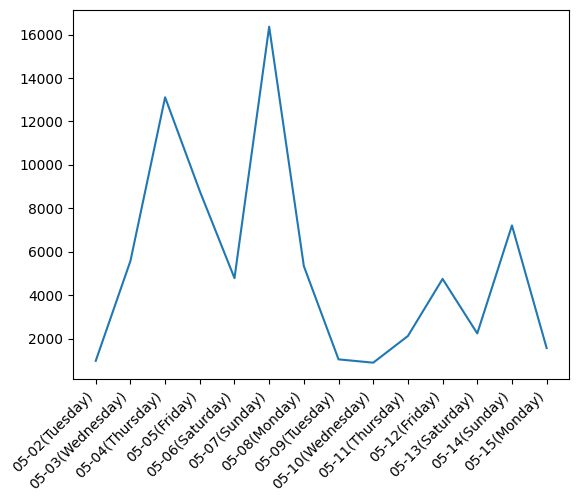

In [8]:
apiCount = {}
for log in eventLogs:
    key = datetime2str(log["timestamp"])
    if key not in apiCount: apiCount[key] = 0
    apiCount[key] += 1

apiCount = list(apiCount.items())
apiCount.sort(key=lambda x: x[0])

fig, ax = plt.subplots()
plt.plot([x[0] for x in apiCount], [x[1] for x in apiCount])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()